In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings('ignore')

import wrangle as wra
import preprocessing as pre

## Retrieving, Splitting, Scaling Data

In [3]:
expanded, score, full_history = wra.get_reports_data('credit_record.csv')

In [4]:
apps = wra.get_application_data('application_record.csv')

In [6]:
apps_cred, apps_none = pre.add_score_target(apps, score)

In [7]:
apps_cred = pre.encode_dummies(apps_cred)

In [8]:
train, validate, test = pre.split_data(apps_cred)

In [9]:
X_train, y_train, X_validate, y_validate, X_test, y_test = pre.create_scaled_x_y(train, validate, test, 'score')

In [11]:
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((26248, 47), (26248,), (6563, 47), (6563,), (3646, 47), (3646,))

## Setting up Baseline

In [14]:
mean = y_train.mean()

In [15]:
median = y_train.median()

In [16]:
baseline = np.array([mean] * X_train.shape[0])
baseline[:5], len(baseline)

(array([26.02095398, 26.02095398, 26.02095398, 26.02095398, 26.02095398]),
 26248)

In [18]:
# Baseline SSE
baseline_residual = y_train - mean
baseline_sse = (baseline_residual**2).sum()
baseline_sse

26382832.475312408

In [19]:
# Baseline MSE
baseline_mse = baseline_sse/X_train.shape[0]
baseline_mse

1005.1368666303111

In [21]:
# Baseline RMSE
baseline_rmse = mean_squared_error(y_train, baseline) ** (1/2)
baseline_rmse

31.703893556317514

## Feature Selection

In [22]:
def select_kbest(X_train_scaled, y_train, k):
    '''
    Takes in the predictors (X_train_scaled), the target (y_train), 
    and the number of features to select (k) 
    and returns the names of the top k selected features based on the SelectKBest class
    '''
    f_selector = SelectKBest(f_regression, k)
    f_selector = f_selector.fit(X_train_scaled, y_train)
    X_train_reduced = f_selector.transform(X_train_scaled)
    f_support = f_selector.get_support()
    f_feature = X_train_scaled.iloc[:,f_support].columns.tolist()
    return f_feature

In [24]:
kbest = select_kbest(X_train, y_train, 10)
kbest

['flag_own_realty',
 'days_birth',
 'days_employed',
 'employed_years',
 'name_education_type_higher_education',
 'name_education_type_lower_secondary',
 'name_housing_type_house_/_apartment',
 'name_housing_type_rented_apartment',
 'occupation_type_medicine_staff',
 'occupation_type_security_staff']

In [25]:
def rfe(X_train_scaled, y_train, k):
    '''
    Takes in the predictor (X_train_scaled), the target (y_train), 
    and the number of features to select (k).
    Returns the top k features based on the RFE class.
    '''
    lm = LinearRegression()
    rfe = RFE(lm, k)
    # Transforming data using RFE
    X_rfe = rfe.fit_transform(X_train_scaled, y_train)
    #Fitting the data to model
    lm.fit(X_rfe,y_train)
    mask = rfe.support_
    rfe_features = X_train_scaled.loc[:,mask].columns.tolist()
    return rfe_features

In [26]:
rfe_features = rfe(X_train, y_train, 10)
rfe_features

['name_housing_type_co-op_apartment',
 'name_housing_type_house_/_apartment',
 'name_housing_type_municipal_apartment',
 'name_housing_type_office_apartment',
 'name_housing_type_rented_apartment',
 'name_housing_type_with_parents',
 'occupation_type_core_staff',
 'occupation_type_laborers',
 'occupation_type_sales_staff',
 'occupation_type_waiters/barmen_staff']

In [27]:
X_train_kbest = X_train[kbest]
X_train_rfe = X_train[rfe_features]

In [30]:
X_train_kbest.columns, X_train_rfe.columns

(Index(['flag_own_realty', 'days_birth', 'days_employed', 'employed_years',
        'name_education_type_higher_education',
        'name_education_type_lower_secondary',
        'name_housing_type_house_/_apartment',
        'name_housing_type_rented_apartment', 'occupation_type_medicine_staff',
        'occupation_type_security_staff'],
       dtype='object'),
 Index(['name_housing_type_co-op_apartment',
        'name_housing_type_house_/_apartment',
        'name_housing_type_municipal_apartment',
        'name_housing_type_office_apartment',
        'name_housing_type_rented_apartment', 'name_housing_type_with_parents',
        'occupation_type_core_staff', 'occupation_type_laborers',
        'occupation_type_sales_staff', 'occupation_type_waiters/barmen_staff'],
       dtype='object'))

In [31]:
y_train.head(1)

32073   -40.0
Name: score, dtype: float64

In [40]:
def plot_residuals(actual, predicted, feature):
    """
    Returns the scatterplot of actural y in horizontal axis and residuals in vertical axis
    Parameters: actural y(df.se), predicted y(df.se), feature(str)
    Prerequisite: call function evaluate_slr
    """
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title(f'Actual vs Residual on {feature}')
    plt.gca()
    return plt.gca()

## Linear Regression Model

In [33]:
# Create Linear Regression model
lm = LinearRegression()

### Using SelectKBest Features

In [34]:
# Fit X_train data containing features from SelectKBest and calculate the RMSE

lm_kbest = lm.fit(X_train_kbest, y_train)
lm_kbest_pred = lm_kbest.predict(X_train_kbest)
lm_kbest_rmse = mean_squared_error(y_train, lm_kbest_pred) ** (1/2)

lm_kbest_rmse

31.648662643239504

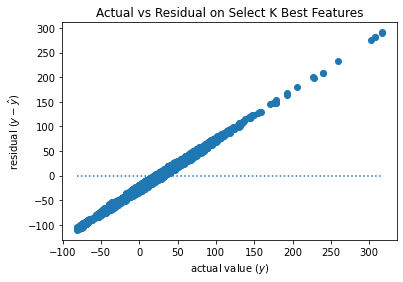

In [47]:
# Residual Plot
plt.subplot(111)
plot_residuals(y_train, lm_kbest_pred, 'Select K Best Features')
plt.show()

### Using RFE Determined Features

In [36]:
# Fit X_train data containing features from RFE and calculate the RMSE

lm_rfe = lm.fit(X_train_rfe, y_train)
lm_rfe_pred = lm_rfe.predict(X_train_rfe)
lm_rfe_rmse = mean_squared_error(y_train, lm_rfe_pred) ** (1/2)

lm_rfe_rmse

31.682406988840505

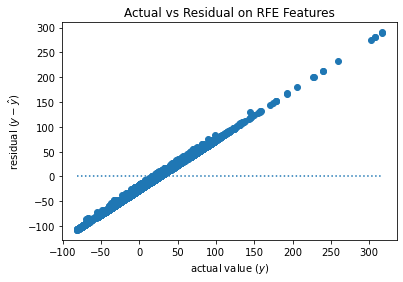

In [48]:
# Residual Plot
plt.subplot(111)
plot_residuals(y_train, lm_rfe_pred, 'RFE Features')
plt.show()

### Model Performance Summary

In [49]:
rmse_values = [baseline_rmse, lm_kbest_rmse, lm_rfe_rmse]
rmse_index = ['Baseline RMSE', 'Linear Regression w/ KBest RMSE', 'Linear Regression w/ RFE RMSE']
summary = pd.DataFrame(rmse_values, index=rmse_index, columns = ['RMSE'])
summary.sort_values(by='RMSE')

,RMSE
Linear Regression w/ KBest RMSE,31.648663
Linear Regression w/ RFE RMSE,31.682407
Baseline RMSE,31.703894


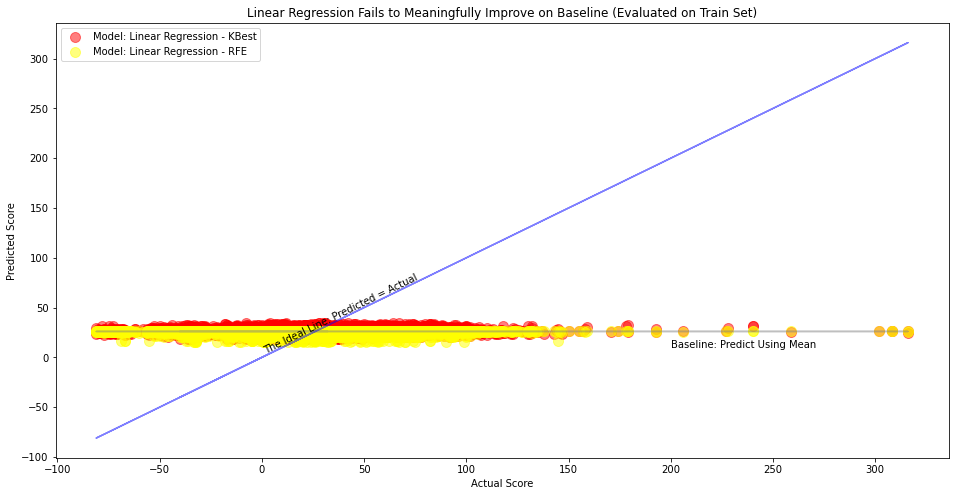

In [55]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_train, baseline, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (200, 9.5))
plt.plot(y_train, y_train, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=26)

plt.scatter(y_train, lm_kbest_pred, 
            alpha=.5, color="red", s=100, label="Model: Linear Regression - KBest")
plt.scatter(y_train, lm_rfe_pred, 
            alpha=.5, color="yellow", s=100, label="Model: Linear Regression - RFE")

plt.legend()
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Linear Regression Fails to Meaningfully Improve on Baseline (Evaluated on Train Set)")
plt.show()